# Darcy' Equation
## A 2+1 Dimensional Numerical Experiment of FNOs

This notebook walks through the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the paper [Fourier Neural Operator for
Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf).

In [1]:
from typing import Any, Generic, NamedTuple, Optional, TypeVar

from ipywidgets import interact, widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer

from torch.nn.functional import mse_loss
import torch

from neuralop import count_params
from neuralop.datasets import load_darcy_flow_small
from neuralop.layers import SpectralConv2d
from neuralop.models import FNO2d
from neuralop.training import LpLoss

torch.manual_seed(0)
np.random.seed(0)

In [2]:
################################################################
# fourier layer
################################################################
print(
"""
The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the coefficient function and locations (a(x, y), x, y)
input shape: (batchsize, x=s, y=s, c=3)
output: the solution 
output shape: (batchsize, x=s, y=s, c=1)
"""
)


The overall network. It contains 4 layers of the Fourier layer.
1. Lift the input to the desire channel dimension by self.fc0 .
2. 4 layers of the integral operators u' = (W + K)(u).
W defined by self.w; K defined by self.conv .
3. Project from the channel space to the output space by self.fc1 and self.fc2 .

input: the solution of the coefficient function and locations (a(x, y), x, y)
input shape: (batchsize, x=s, y=s, c=3)
output: the solution 
output shape: (batchsize, x=s, y=s, c=1)



In [3]:
################################################################
# configs
################################################################
# Support for generics added in Python 3.11
# T = TypeVar('T')  # Declare type variable "T"
# class WidgetArgs(NamedTuple, Generic[T]): pass

class WidgetArgs(NamedTuple):
    description: str
    value: Any
    tooltip: Optional[str] = None
    disabled: Optional[bool] = None


class StringWidgetArgs(WidgetArgs):
    value: str


class IntegerWidgetArgs(WidgetArgs):
    value: int


class FloatWidgetArgs(WidgetArgs):
    value: float


class Config:
    train_path: str
    test_path: str
    n_train: int
    n_test: int
    train_batch_size: int
    test_batch_size: int
    learning_rate: float
    epochs: int
    iterations: int
    modes: int
    width: int
    r: int
    h: int
    # s: int  # same as h

    def __init__(
        self, 
        train_path: StringWidgetArgs,
        test_path: StringWidgetArgs,
        n_train: IntegerWidgetArgs,
        n_test: IntegerWidgetArgs,
        train_batch_size: IntegerWidgetArgs,
        test_batch_size: IntegerWidgetArgs,
        learning_rate: FloatWidgetArgs,
        epochs: IntegerWidgetArgs,
        iterations: IntegerWidgetArgs,
        modes: IntegerWidgetArgs,
        width: IntegerWidgetArgs,
        r: IntegerWidgetArgs,
        h: IntegerWidgetArgs,
    ):
        self.train_path = train_path.value
        self.test_path = test_path.value
        self.n_train = n_train.value
        self.n_test = n_test.value
        self.train_batch_size = train_batch_size.value
        self.test_batch_size = test_batch_size.value
        self.learning_rate = learning_rate.value
        self.epochs = epochs.value
        # Ignore iterations.value until manually set:
        self.iterations = epochs.value * (n_train.value // train_batch_size.value)
        self.modes = modes.value
        self.width = width.value
        self.r = r.value
        self.h = h.value

        self.widgets = {}
        for string_name, args in (
            ('train_path', train_path),
            ('test_path', test_path),
        ):
            tooltip = args.description if args.tooltip is None else args.tooltip
            disabled = args.disabled or False
            print(string_name, tooltip)
            widget = widgets.Textarea(
                value=args.value,
                description=args.description,
                tooltip=tooltip,
                disabled=disabled,
            )
            def _observe(w):
                setattr(self, string_name, str(w.value))
            widget.observe(_observe)
            self.widgets[string_name] = widget

        for int_name, args in (
            ('n_train', n_train),
            ('n_test', n_test),
            ('train_batch_size', train_batch_size),
            ('test_batch_size', test_batch_size),
            ('epochs', epochs),
            ('iterations', iterations),
            ('modes', modes),
            ('width', width),
            ('r', r),
            ('h', h),
        ):
            # print(int_name, args.value)
            tooltip = args.description if args.tooltip is None else args.tooltip
            disabled = args.disabled or False
            print(int_name, tooltip)
            widget = widgets.IntText(
                value=args.value,
                description=args.description,
                tooltip=tooltip,
                disabled=disabled,
            )
            def _observe(w):
                setattr(self, string_name, int(w.value))
            widget.observe(_observe)
            self.widgets[int_name] = widget
            # print(len(self.widgets))

        # We have only one float config: learning_rate
        tooltip = learning_rate.description if learning_rate.tooltip is None else learning_rate.tooltip
        disabled = learning_rate.disabled or False
        widget = widgets.FloatText(
            value=learning_rate.value,
            description=learning_rate.description,
            tooltip=tooltip,
            disabled=disabled,
        )
        def _observe(w):
            self.learning_rate = float(w.value)
        widget.observe(_observe)
        self.widgets['learning_rate'] = widget

        for widget in self.widgets.values():
            display(widget)
    

cfg = Config(
    StringWidgetArgs(
        'Training file:',
        'data/piececonst_r421_N1024_smooth1.mat',
        'Fully qualified file path to training data',
    ),
    StringWidgetArgs(
        'Testing file:',
        'data/piececonst_r421_N1024_smooth2.mat',
        'Fully qualified file path to testing data',
    ),
    IntegerWidgetArgs(
        'Training size:',
        1000,
        'Training set size',
    ),
    IntegerWidgetArgs(
        'Testing size:',
        100,
        'Testing set size',
    ),
    IntegerWidgetArgs('Training batch size:', 20),
    IntegerWidgetArgs('Testing batch size:', 10),
    FloatWidgetArgs('Learning rate:', 0.002),
    # WidgetArgs('Epochs:', 500),
    IntegerWidgetArgs('Epochs:', 100),
    IntegerWidgetArgs('Iterations:', 5000),
    IntegerWidgetArgs('Modes:', 12),
    IntegerWidgetArgs(
        'Width:',
        32,
        'The width of all hidden layers'
    ),
    IntegerWidgetArgs('R:', 5),
    IntegerWidgetArgs('H:', 73),        
)

# TODO fix on_submit callback

train_path Fully qualified file path to training data
test_path Fully qualified file path to testing data
n_train Training set size
n_test Testing set size
train_batch_size Training batch size:
test_batch_size Testing batch size:
epochs Epochs:
iterations Iterations:
modes Modes:
width The width of all hidden layers
r R:
h H:


Textarea(value='data/piececonst_r421_N1024_smooth1.mat', description='Training file:')

Textarea(value='data/piececonst_r421_N1024_smooth2.mat', description='Testing file:')

IntText(value=1000, description='Training size:')

IntText(value=100, description='Testing size:')

IntText(value=20, description='Training batch size:')

IntText(value=10, description='Testing batch size:')

IntText(value=100, description='Epochs:')

IntText(value=5000, description='Iterations:')

IntText(value=12, description='Modes:')

IntText(value=32, description='Width:')

IntText(value=5, description='R:')

IntText(value=73, description='H:')

FloatText(value=0.002, description='Learning rate:')

In [4]:
################################################################
# load data and data normalization
################################################################

# Assumes there exist training and testing data .pt files at
# `neuralop/data/darcy_train_RES.pt`, and
# `neuralop/data/darcy_test_RES.pt`
# for training and testing resolution RES 16 or 32
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    cfg.n_train,
    [cfg.n_test],
    cfg.train_batch_size,  # train_batch_size
    [cfg.test_batch_size],  # test_batch_sizes
)

In [11]:
model = FNO2d(
    cfg.modes,  # modes_width
    cfg.modes,  # modes_height
    cfg.width,  # width of all hidden layers
    in_channels=3,  # input channels are 3: (a(x, y), x, y)
    out_channels=1,  # output channel is 1: u(x, y)
    n_layers=4,
    domain_padding=9,
    domain_padding_mode='one-sided',
    use_mlp=True,
).cuda()
print("Model parameter count:", count_params(model))

Model parameter count: 607297


In [12]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg.learning_rate,
    weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=cfg.iterations
)

loss_fn = LpLoss()  # By default, does not do size averaging
output_encoder.cuda()
for ep in range(cfg.epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for train_data in train_loader:
        x, y = train_data['x'].cuda(), train_data['y'].cuda()
    
        optimizer.zero_grad()
        # out = model(x).reshape(batch_size, s, s)
        out = model(x).reshape(cfg.train_batch_size, 16, 16)
        out = output_encoder.decode(out)
        y = output_encoder.decode(y)
    
        loss = loss_fn(
            out.view(cfg.train_batch_size, -1),
            y.view(cfg.train_batch_size, -1)
        )
        loss.backward()
    
        optimizer.step()
        scheduler.step()
        train_l2 += loss.item()
    
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for test_data in test_loaders[16]:
            x, y = test_data['x'].cuda(), test_data['y'].cuda()

            # out = model(x).reshape(batch_size, s, s)
            out = model(x).reshape(cfg.test_batch_size, 16, 16)
            out = output_encoder.decode(out)
    
            test_l2 += loss_fn(
                out.view(cfg.test_batch_size, -1),
                y.view(cfg.test_batch_size, -1),
            ).item()
    
    train_l2 /= cfg.n_train
    test_l2 /= cfg.n_test
    
    t2 = default_timer()
    print(
        f'Epoch # {ep}',
        f'Duration:     {t2 - t1:9.5f}',
        f'Training L2:  {train_l2:9.5f}',
        f'Testing L2:   {test_l2:9.5f}',
        '=' * 32,
        sep='\n',
    )

Padding inputs of resolution=torch.Size([16, 16]) with padding=[144, 144], one-sided
Epoch # 0
Duration:       3.14242
Training L2:    0.49610
Testing L2:     0.19907
Epoch # 1
Duration:       3.13037
Training L2:    0.36166
Testing L2:     0.16355
Epoch # 2
Duration:       3.12955
Training L2:    0.32980
Testing L2:     0.14996
Epoch # 3
Duration:       3.13100
Training L2:    0.30111
Testing L2:     0.13704
Epoch # 4
Duration:       3.13018
Training L2:    0.28177
Testing L2:     0.12881
Epoch # 5
Duration:       3.13062
Training L2:    0.27377
Testing L2:     0.12865
Epoch # 6
Duration:       3.13068
Training L2:    0.26578
Testing L2:     0.12558
Epoch # 7
Duration:       3.13054
Training L2:    0.26077
Testing L2:     0.12258
Epoch # 8
Duration:       3.13125
Training L2:    0.25605
Testing L2:     0.11880
Epoch # 9
Duration:       3.13084
Training L2:    0.25168
Testing L2:     0.11950
Epoch # 10
Duration:       3.13110
Training L2:    0.25225
Testing L2:     0.11616
Epoch # 11
D

Epoch # 70
Duration:       3.13452
Training L2:    0.18187
Testing L2:     0.08532
Epoch # 71
Duration:       3.13421
Training L2:    0.18155
Testing L2:     0.08727
Epoch # 72
Duration:       3.13580
Training L2:    0.18104
Testing L2:     0.08796
Epoch # 73
Duration:       3.13495
Training L2:    0.17974
Testing L2:     0.08693
Epoch # 74
Duration:       3.13549
Training L2:    0.18056
Testing L2:     0.08601
Epoch # 75
Duration:       3.13506
Training L2:    0.18140
Testing L2:     0.08477
Epoch # 76
Duration:       3.13569
Training L2:    0.17902
Testing L2:     0.08676
Epoch # 77
Duration:       3.13560
Training L2:    0.17807
Testing L2:     0.08587
Epoch # 78
Duration:       3.13594
Training L2:    0.17721
Testing L2:     0.08763
Epoch # 79
Duration:       3.13607
Training L2:    0.17762
Testing L2:     0.08599
Epoch # 80
Duration:       3.13446
Training L2:    0.17751
Testing L2:     0.08554
Epoch # 81
Duration:       3.13611
Training L2:    0.17616
Testing L2:     0.08453
Epoc

## Visualization

Visualize the error in the trained model against a subsample of testing data points (i.e. field values from time t=0 to be mapped to t=1). Also visualize the error (squared to be non-negative).

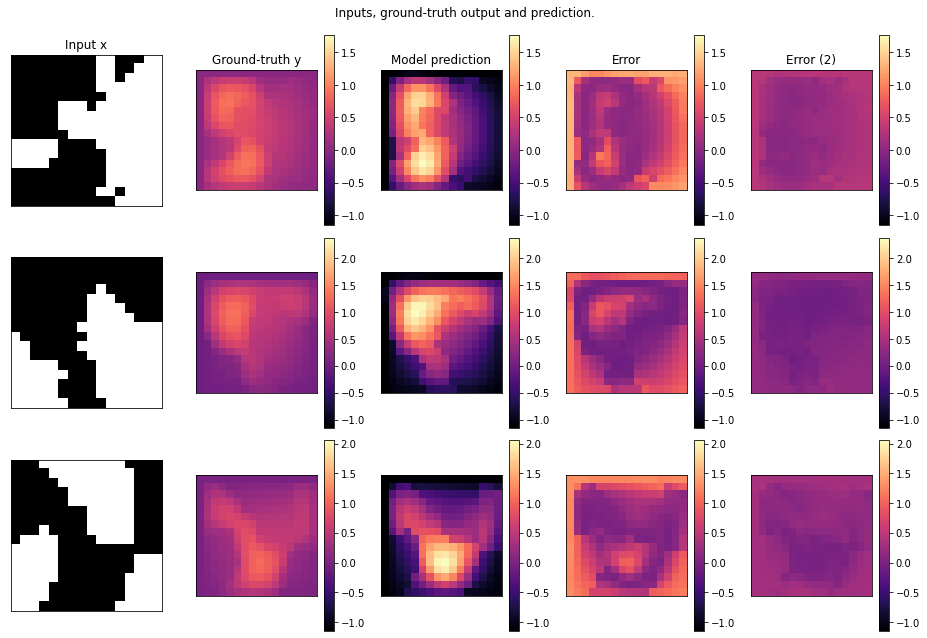

In [13]:
test_samples = test_loaders[16].dataset
n_rows = 3
n_cols = 5

fig = plt.figure(figsize=(13,  # width (inches)
                          9))  # height (inches)
for index in range(n_rows):
    data = test_samples[index]
    # Input x
    x = data['x'].cuda()
    # Ground-truth
    y = data['y'].cuda()
    # Model prediction
    out = model(x.unsqueeze(0))
    error = (out - y).square()
    error2 = (out / 2 - y).square()
    vmin = min(y.min(), out.min(), error.min(), error2.min())
    vmax = max(y.max(), out.max(), error.max(), error2.max())

    ax1 = fig.add_subplot(n_rows, n_cols, index * n_cols + 1)
    im1 = ax1.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax1.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    # fig.colorbar(im1, ax=ax1)

    ax2 = fig.add_subplot(n_rows, n_cols, index * n_cols + 2)
    im2 = ax2.imshow(y.squeeze().cpu(), cmap='magma', vmin=vmin, vmax=vmax)
    if index == 0:
        ax2.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im2, ax=ax2)

    ax3 = fig.add_subplot(n_rows, n_cols, index * n_cols + 3)
    im3 = ax3.imshow(
        out.squeeze().detach().cpu(),
        cmap='magma',
        vmin=vmin,
        vmax=vmax
    )
    if index == 0:
        ax3.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im3, ax=ax3)

    ax4 = fig.add_subplot(n_rows, n_cols, index * n_cols + 4)
    im4 = ax4.imshow(
        error.squeeze().detach().cpu(),
        cmap='magma',
        vmin=vmin,
        vmax=vmax
    )
    if index == 0:
        ax4.set_title('Error')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im4, ax=ax4)
    
    ax5 = fig.add_subplot(n_rows, n_cols, index * n_cols + 5)
    im5 = ax5.imshow(
        error2.squeeze().detach().cpu(),
        cmap='magma',
        vmin=vmin,
        vmax=vmax
    )
    if index == 0:
        ax5.set_title('Error (2)')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im5, ax=ax5)
    
    
fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()